# CTD data starter code

In [1]:
import gsw  # TEOS-10 Gibbs SeaWater toolbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Read in the CSV depth series data.

In [2]:
WATER_QUALITY_FILE_PATH = 'your path here'  # e.g. './data/EIMContinuousDepthSeriesData_2024Apr08_229519.csv'
ctd_all_data = pd.read_csv(WATER_QUALITY_FILE_PATH)

In [3]:
ctd_all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229519 entries, 0 to 229518
Data columns (total 30 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   Study_ID                                        229519 non-null  object 
 1   Study_Name                                      229519 non-null  object 
 2   Location_ID                                     229519 non-null  object 
 3   Study_Specific_Location_ID                      229519 non-null  object 
 4   Location_Name                                   229519 non-null  object 
 5   Instrument_ID                                   229519 non-null  object 
 6   Field_Collection_Type                           229519 non-null  object 
 7   Field_Collector                                 229519 non-null  object 
 8   Time_Zone                                       229519 non-null  object 
 9   Field_Collection_Date     

Convert the provided datetime string to a Pandas datetime. The data are UTC according to the original DataFrame's `'Time_Zone'` column.  Note the format `'%m/%d/%Y %I:%M:%S %p'` where `%I` is used in place of `'%H'` to indicate 12-hour time and `%p` is AM/PM.  Here is a helpful guide for date formats: https://strftime.org/.

In [4]:
ctd_all_data['Field_Collection_Date_Time'] = pd.to_datetime(
    ctd_all_data['Field_Collection_Date_Time'],
    format='%m/%d/%Y %I:%M:%S %p',
    utc=True
)

Build a dictionary of parameter units for later use.

In [5]:
parameter_units = {}
for parameter in ctd_all_data['Result_Parameter_Name'].unique():
    unit = (ctd_all_data
           .query('Result_Parameter_Name == @parameter')['Result_Value_Units']
           .unique())[0]
    parameter_units[parameter] = unit

# Also get the depth units, which should all be meters.
parameter_units['Depth'] = ctd_all_data['Depth_Value_Units'].unique()[0]

parameter_units

{'Salinity': 'PSU',
 'Beam Attenuation': 'm^-1',
 'Temperature, water': 'deg C',
 'Density as sigma-t': 'kg/m3-1000',
 'Pressure': 'dbar',
 'Light Transmission': '%',
 'Turbidity': 'NTU',
 'pH': 'pH',
 'Fluorescence': 'mg/m3',
 'Dissolved Oxygen Percent Saturation': '%',
 'Dissolved Oxygen': 'mg/L',
 'Conductivity': 'S/m',
 'Photosynthetically active radiation': 'umol/m2/s',
 'Depth': 'm'}

Get station coordinates:

In [6]:
station_latitude = ctd_all_data['Calculated_Latitude_Decimal_Degrees_NAD83HARN'].unique()[0]
station_longitude = ctd_all_data['Calculated_Longitude_Decimal_Degrees_NAD83HARN'].unique()[0]

Profile data can be challenging to work with in table-like format since the variables are a function of both time and depth.  To work with the data in a familiar format, we can create a multiindex DataFrame which is indexed by `'Field_Collection_Date_Time'` and `'Depth_Value'` and then pivot the table on `'Result_Parameter_Name'` based on the values `'Result_Value'`.  This will remove the remaining variables, however these can be accessed in the original DataFrame `'ctd_all_data'`, if needed.

In [7]:
# Define start and end times to filter data.  Update these as needed.
start_datetime = pd.Timestamp('2017-01-01 00:00:00', tz='UTC')
end_datetime = pd.Timestamp('2017-12-31 00:00:00', tz='UTC')

# Columns that will form the multiindex of the pivot table.
index_columns = ['Field_Collection_Date_Time', 'Depth_Value']

ctd_pivot = (ctd_all_data
    .set_index(index_columns)
    .sort_index()
    .pivot(columns='Result_Parameter_Name', values='Result_Value')
    .loc[start_datetime:end_datetime]
)

ctd_pivot

,Result_Parameter_Name,Beam Attenuation,Conductivity,Density as sigma-t,Dissolved Oxygen,Dissolved Oxygen Percent Saturation,Fluorescence,Light Transmission,Photosynthetically active radiation,Pressure,Salinity,"Temperature, water",Turbidity,pH
Field_Collection_Date_Time,Depth_Value,,,,,,,,,,,,,
2017-02-07 21:05:27+00:00,1.5,0.4200,NaN,NaN,NaN,NaN,0.815731,90.0325,1027.60,1.513,NaN,7.6185,NaN,NaN
2017-02-07 21:05:28+00:00,2.0,0.4220,NaN,NaN,NaN,NaN,0.830448,89.9873,497.08,2.017,NaN,7.6119,NaN,NaN
2017-02-07 21:05:29+00:00,2.5,0.4208,NaN,NaN,NaN,NaN,0.874598,90.0138,457.78,2.521,NaN,7.6024,NaN,NaN
2017-02-07 21:05:31+00:00,3.0,0.4141,NaN,NaN,NaN,NaN,0.874598,90.1642,398.36,3.026,NaN,7.6113,NaN,NaN
2017-02-07 21:05:32+00:00,3.5,0.4206,NaN,NaN,NaN,NaN,0.853574,90.0187,370.30,3.530,NaN,7.6062,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-06 19:33:56+00:00,73.0,1.0265,3.356845,24.0204,7.017488,74.48377,0.853608,77.3663,NaN,73.634,31.0785,9.1871,NaN,NaN
2017-12-06 19:33:57+00:00,73.5,0.9950,3.356778,24.0195,7.037925,74.70098,0.845866,77.9790,NaN,74.139,31.0775,9.1873,NaN,NaN
2017-12-06 19:33:58+00:00,74.0,1.0290,3.356767,24.0191,7.029686,74.61324,0.822639,77.3245,NaN,74.643,31.0770,9.1875,NaN,NaN


Define functions for plotting profiles:

In [8]:
def plot_depth_profile(profile, ax=None, label_axes=True, **kwargs):
    """ Plot the depth profile of a parameter Series. """
    if ax is None:
        ax = plt.gca()

    sc = ax.scatter(
        x=profile,
        y=-profile.index.get_level_values('Depth_Value'),
        **kwargs,
    )
    if label_axes:
        label_profile_axes(profile.name, ax)
    return sc

def plot_depth_profile_by_month(profile, ax=None, label_axes=True, **kwargs):
    """ Plot the depth profile of a parameter Series and color it by month. """
    # Call the profile plot function and pass the month as the color.
    sc = plot_depth_profile(
        profile=profile,
        ax=ax,
        label_axes=label_axes,
        c=profile.index.get_level_values('Field_Collection_Date_Time').month,
        **kwargs,
    )
    return sc

def label_profile_axes(parameter, ax=None, **kwargs):
    """ Label a profile plot's axes with the appropriate units. """
    if ax is None:
        ax = plt.gca()
    ax.set_xlabel(f'{parameter} [{parameter_units[parameter]}]', **kwargs)
    ax.set_ylabel(f'Depth [{parameter_units['Depth']}]', **kwargs)


Plot a profile:

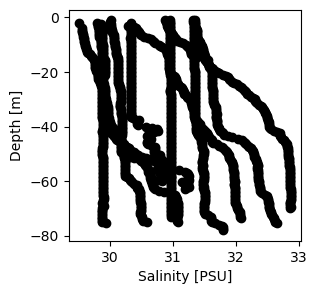

In [9]:
fig, ax = plt.subplots(figsize =(3,3))
plot_depth_profile(ctd_pivot['Salinity'], ax=ax, color='k', label_axes=True)

Plot a few profiles colored by month:

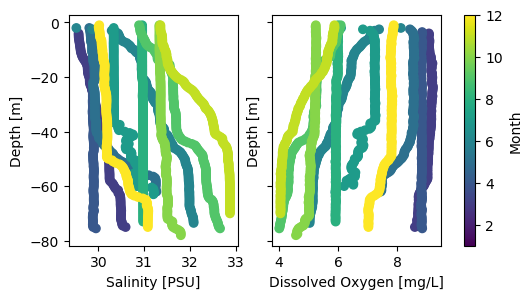

In [10]:
profile_plot_kwargs = dict(
    norm=mpl.colors.Normalize(vmin=1, vmax=12),  # uniform colormap extent
    cmap='viridis',
    label_axes=True,
)

fig, ax = plt.subplots(1, 2, figsize =(6,3), sharey=True) #
sc = plot_depth_profile_by_month(ctd_pivot['Salinity'], ax=ax[0], **profile_plot_kwargs)
plot_depth_profile_by_month(ctd_pivot['Dissolved Oxygen'], ax=ax[1], **profile_plot_kwargs)

cbar = fig.colorbar(sc, ax=ax, label='Month')

Example use of the TEOS-10 Gibbs SeaWater (GSW) Oceanographic Toolbox:

In [11]:
ctd_pivot['Reference_Salinity'] = gsw.SR_from_SP(SP=ctd_pivot["Salinity"])

# Update units dictionary
parameter_units['Reference_Salinity'] = 'g/kg'

ctd_pivot

,Result_Parameter_Name,Beam Attenuation,Conductivity,Density as sigma-t,Dissolved Oxygen,Dissolved Oxygen Percent Saturation,Fluorescence,Light Transmission,Photosynthetically active radiation,Pressure,Salinity,"Temperature, water",Turbidity,pH,Reference_Salinity
Field_Collection_Date_Time,Depth_Value,,,,,,,,,,,,,,
2017-02-07 21:05:27+00:00,1.5,0.4200,NaN,NaN,NaN,NaN,0.815731,90.0325,1027.60,1.513,NaN,7.6185,NaN,NaN,NaN
2017-02-07 21:05:28+00:00,2.0,0.4220,NaN,NaN,NaN,NaN,0.830448,89.9873,497.08,2.017,NaN,7.6119,NaN,NaN,NaN
2017-02-07 21:05:29+00:00,2.5,0.4208,NaN,NaN,NaN,NaN,0.874598,90.0138,457.78,2.521,NaN,7.6024,NaN,NaN,NaN
2017-02-07 21:05:31+00:00,3.0,0.4141,NaN,NaN,NaN,NaN,0.874598,90.1642,398.36,3.026,NaN,7.6113,NaN,NaN,NaN
2017-02-07 21:05:32+00:00,3.5,0.4206,NaN,NaN,NaN,NaN,0.853574,90.0187,370.30,3.530,NaN,7.6062,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-06 19:33:56+00:00,73.0,1.0265,3.356845,24.0204,7.017488,74.48377,0.853608,77.3663,NaN,73.634,31.0785,9.1871,NaN,NaN,31.225048
2017-12-06 19:33:57+00:00,73.5,0.9950,3.356778,24.0195,7.037925,74.70098,0.845866,77.9790,NaN,74.139,31.0775,9.1873,NaN,NaN,31.224044
2017-12-06 19:33:58+00:00,74.0,1.0290,3.356767,24.0191,7.029686,74.61324,0.822639,77.3245,NaN,74.643,31.0770,9.1875,NaN,NaN,31.223541


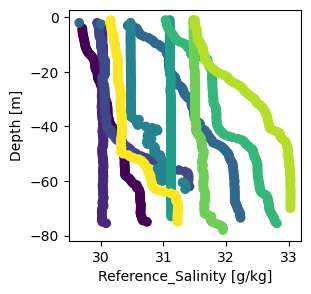

In [12]:
fig, ax = plt.subplots(figsize =(3,3))
plot_depth_profile_by_month(ctd_pivot['Reference_Salinity'], ax=ax)